# Project: Application of classification models

Dataset Link

https://archive.ics.uci.edu/ml/machine-learning-databases/adult/

Problem 1:
Prediction task is to determine whether a person makes over 50K a year.

Problem 2:
Which factors are important

Problem 3:
Which algorithms are best for this dataset

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None  # default='warn'

We have been given the train and test data sets separately. Let's load them into pd dataframes.

In [2]:
names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
         "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", 
         "hours-per-week", "native-country", "income"]

original_train = pd.read_csv('adult.data.csv', sep=',', header=None, names=names, na_values="?")
original_test = pd.read_csv('adult.test.csv', sep=',', header=None, names=names, na_values="?")

#drop the rows containing missing values
original_train.dropna(inplace=True)
original_test.dropna(inplace=True)

# remove spaces after comma for pandas convenience
original_train[original_train.select_dtypes(['object']).columns] = original_train.select_dtypes(['object']).apply(lambda x: x.str.strip())
original_test[original_test.select_dtypes(['object']).columns] = original_test.select_dtypes(['object']).apply(lambda x: x.str.strip())

In [3]:
original_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Data Exploration

Let’s plot the distribution of each feature, so that we have a better understanding what we have in our data. We draw the number of values for each category feature and the histogram of the values for each continuous feature.

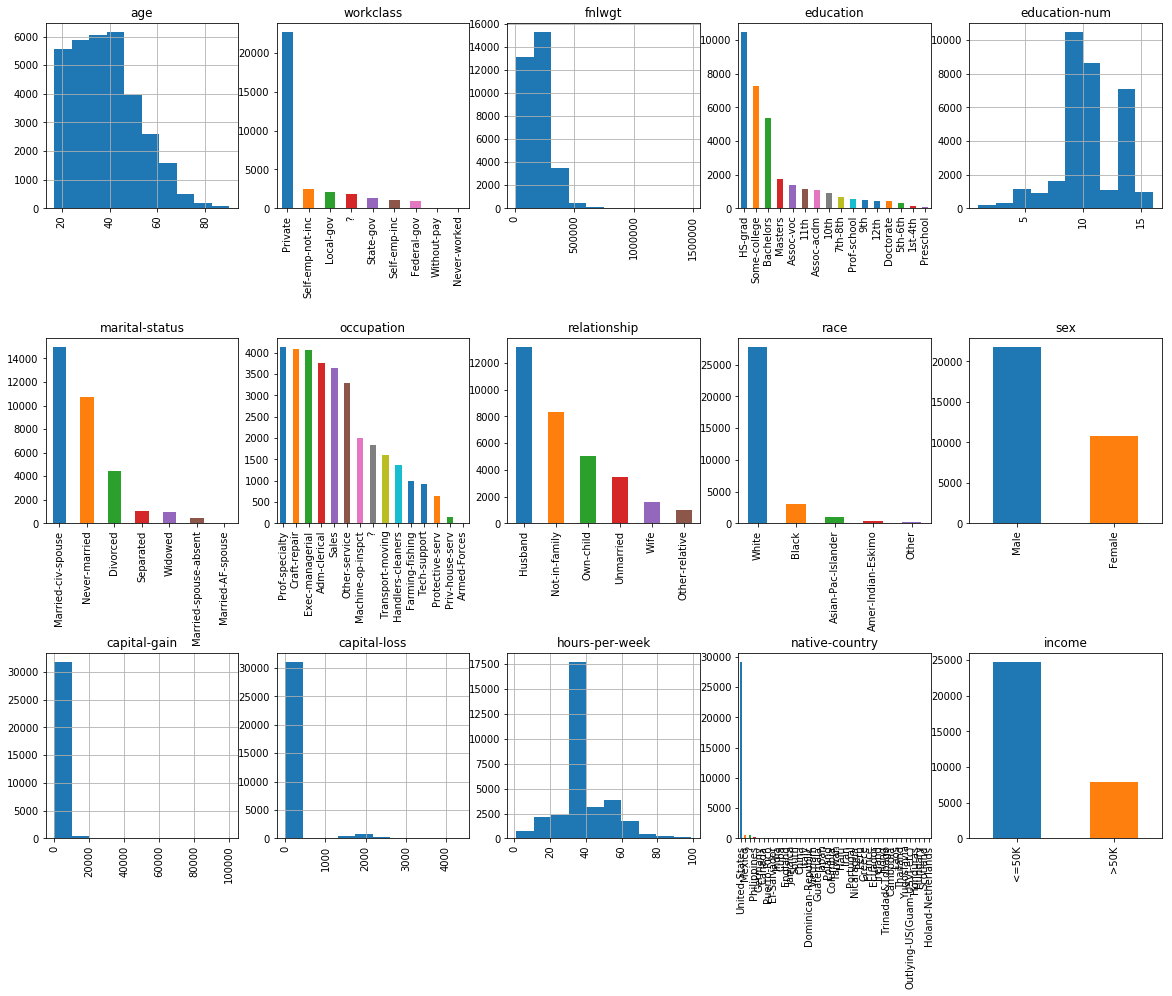

In [4]:
from math import ceil

fig = plt.figure(figsize=(20,15))
cols = 5
rows = ceil(float(original_train.shape[1]) / cols)
for i, column in enumerate(original_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if original_train.dtypes[column] == np.object:
        original_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        original_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

We can see from the plots that our data is mostly concentrated in the USA with mostly male white people.

Let’s explore the correlation between the different features. Generally it is not a good idea to have many correlated features, as it might be a sign that your data is not very good. For this purpose we will need to encode the categorical features as numbers.

# Data pre-processing

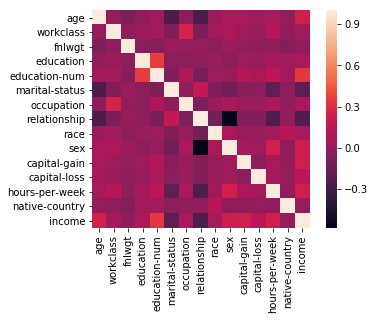

In [5]:
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

# Calculate the correlation and plot it
encoded_train, _ = number_encode_features(original_train)
sns.heatmap(encoded_train.corr(), square=True)
plt.show()

We see there is a high correlation between Education and Education-Num. They actually represent the same features, but encoded as strings and as numbers. We don’t need the string representation, so we can just delete this column. Note that it is a much better option to delete the Education column as the Education-Num has the important property that the values are ordered: the higher the number, the higher the education that person has.

In [6]:
original_train.drop(['education'], axis=1, inplace=True)
encoded_train.drop(['education'], axis=1, inplace=True)
original_test.drop(['education'], axis=1, inplace=True)

Other than that, the data is mostly OK with the exception of Sex and Relationship, which seems to be negatively correlated.

In [7]:
#Encode data in test dataframe 

encoded_test, _ = number_encode_features(original_test)

# Build the model

# Logistic Regression

In [8]:
seed = np.random.randint(2**16)

In [9]:
# train set
X_train = encoded_train.drop(columns=['income'], axis=1)
y_train = encoded_train['income']

# test set
X_test = encoded_test.drop(columns=['income'], axis=1)
y_test = encoded_test['income']

# scale the columns between 0 and 1 (normalization)
X_scaler = StandardScaler()
X_train = pd.DataFrame(X_scaler.fit_transform(X_train), columns=X_train.columns)
X_test = X_scaler.transform(X_test)

In [10]:
lrmodel = LogisticRegression(random_state=seed)
lrmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=7248, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [11]:
predicted = lrmodel.predict(X_test)
predicted

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

Test Accuracy: 82.45 %
F1 Score: 0.55


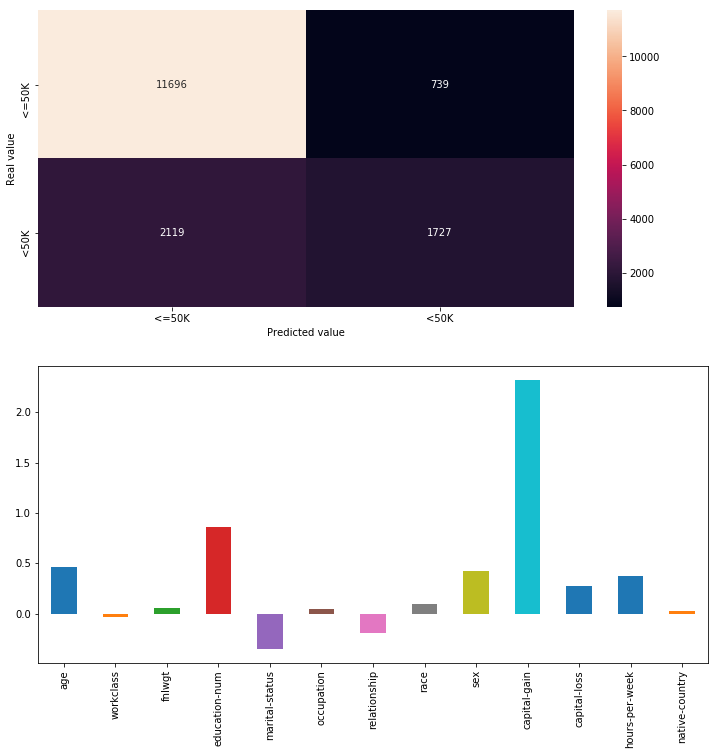

In [12]:
# evaluation metrics
print("Test Accuracy:", format(metrics.accuracy_score(y_test, predicted) * 100, '.2f'), '%')
print("F1 Score:", format(metrics.f1_score(y_test, predicted), '.2f'))

cm = metrics.confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['<=50K', '<50K'], yticklabels=['<=50K', '<50K'])
plt.ylabel("Real value")
plt.xlabel("Predicted value")

coefs = pd.Series(lrmodel.coef_[0], index=X_train.columns)
plt.subplot(2,1,2)
coefs.plot(kind="bar")
plt.show()

As you can see we managed to achieve F1 score of 0.55 and the features that seems to contribute most positively to have an income of more than $50K are Capital Gain, Education-Num, Sex & age, while the features that contribute most negatively are Martia Status and Relationship.

Features like martial status have values ranging from 0 to 6, and there is no particular order in that feature (unlike Education-Num for which the higher the number, the better the education). We can fix this issue using dummy features.

In [13]:
# category columns
train_category = original_train[['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']]

#numeric columns
train_numeric = original_train[np.setdiff1d(encoded_train.columns.tolist(), train_category.columns.tolist())]

# dummify the category column
train_category_dummy = pd.get_dummies(train_category, columns=['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'])

# merge
modified_train = pd.concat([train_category_dummy, train_numeric], axis=1)

In [14]:
# do the same for test data set

test_category = original_test[['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']]
test_numeric = original_test[np.setdiff1d(encoded_test.columns.tolist(), test_category.columns.tolist())]
test_category_dummy = pd.get_dummies(test_category, columns=['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'])
modified_test = pd.concat([test_category_dummy, test_numeric], axis=1)

In [15]:
modified_train['income'] = modified_train['income'].map( {'<=50K': 0, '>50K': 1} )
modified_test['income'] = modified_test['income'].map( {'<=50K': 0, '>50K': 1} )
modified_train.drop(['native-country_Holand-Netherlands'], axis=1, inplace=True)

In [16]:
# train set
X_train = modified_train.drop(columns=['income'], axis=1)
y_train = modified_train['income']

# test set
X_test = modified_test.drop(columns=['income'], axis=1)
y_test = modified_test['income']

X_scaler = StandardScaler()
X_train = pd.DataFrame(X_scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(X_scaler.fit_transform(X_test), columns=X_test.columns)

In [17]:
lrmodel = LogisticRegression(random_state=seed)
lrmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=7248, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
predicted = lrmodel.predict(X_test)

Test Accuracy: 85.28 %
F1 Score: 0.66


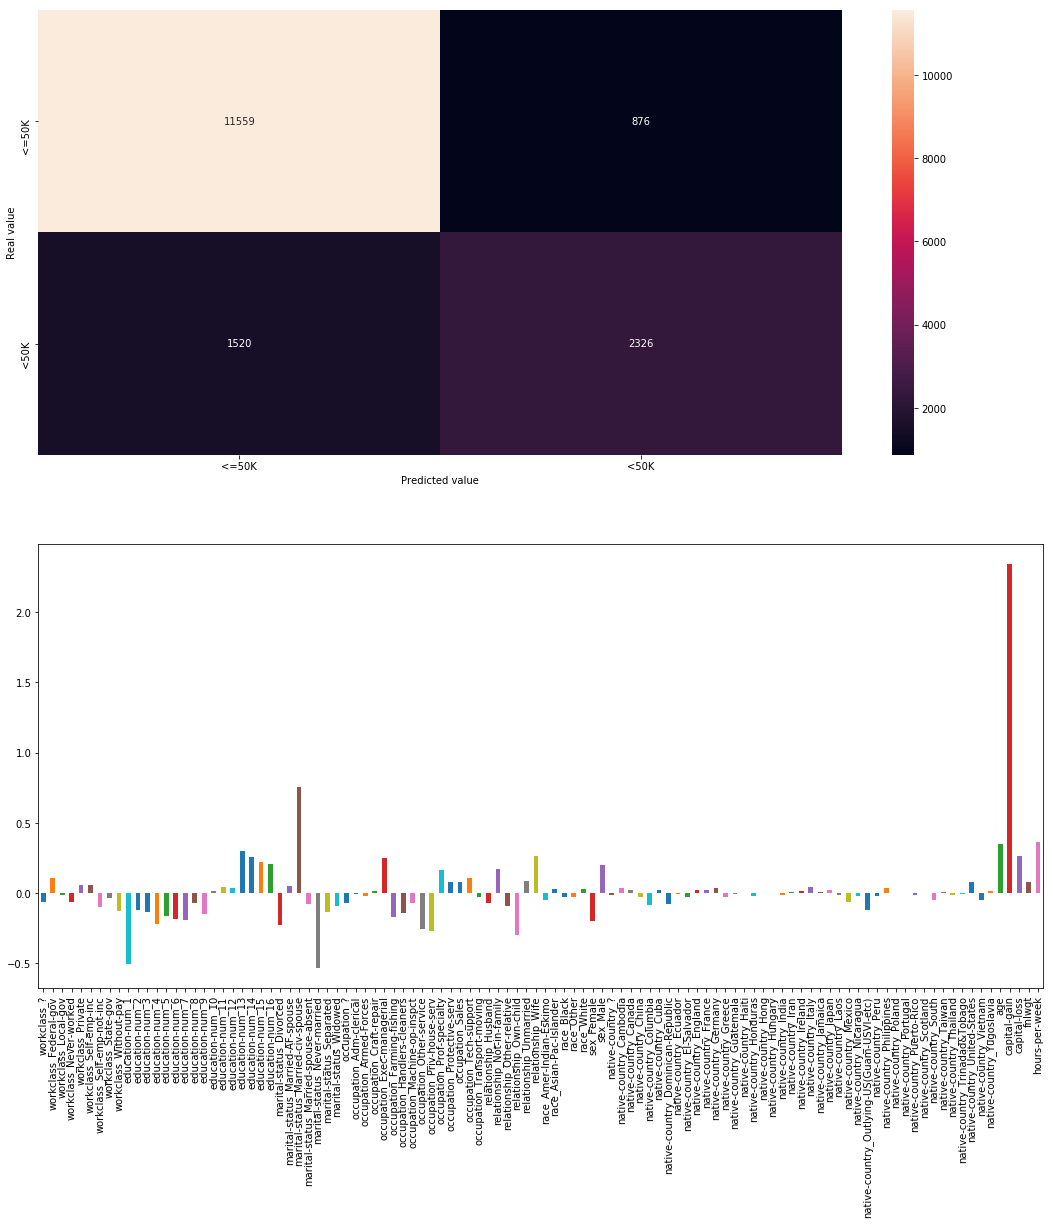

In [19]:
# evaluation metrics
print("Test Accuracy:", format(metrics.accuracy_score(y_test, predicted) * 100, '.2f'), '%')
print("F1 Score:", format(metrics.f1_score(y_test, predicted), '.2f'))

cm = metrics.confusion_matrix(y_test, predicted)
plt.figure(figsize=(18,18))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['<=50K', '<50K'], yticklabels=['<=50K', '<50K'])
plt.ylabel("Real value")
plt.xlabel("Predicted value")

coefs = pd.Series(lrmodel.coef_[0], index=X_train.columns)
plt.subplot(2,1,2)
coefs.plot(kind="bar")
plt.show()

We managed to improve the accuracy and F1 scores by converting the data to use dummy variables. Also it seems that we managed to uncover some interesting insight from our model. It seems that the features that impacts the income of a person positively are Capital Gain, Married-civ-spounce, Age, Hours per week and Exec-managerial. The features that impact it most negatively are Never married, Own child, Priv-house-serv, Divorsed and Female.

# Random Forest Classifier

In [20]:
# train set
X_train = encoded_train.drop(columns=['income'], axis=1)
y_train = encoded_train['income']

# test set
X_test = encoded_test.drop(columns=['income'], axis=1)
y_test = encoded_test['income']

# scale the numeric columns between 0 and 1 (normalization)
X_scaler = StandardScaler()
X_train = pd.DataFrame(X_scaler.fit_transform(X_train), columns=X_train.columns)
X_test = X_scaler.transform(X_test)

In [21]:
# Instantiate a random forest model and fit the training set.

rfmodel = RandomForestClassifier(n_jobs=-1, random_state=seed)
rfmodel.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=7248, verbose=0,
            warm_start=False)

In [22]:
predicted = rfmodel.predict(X_test)
predicted

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

Test Accuracy: 85.31 %
F1 Score: 0.65


Text(0.5,442.811,'Predicted value')

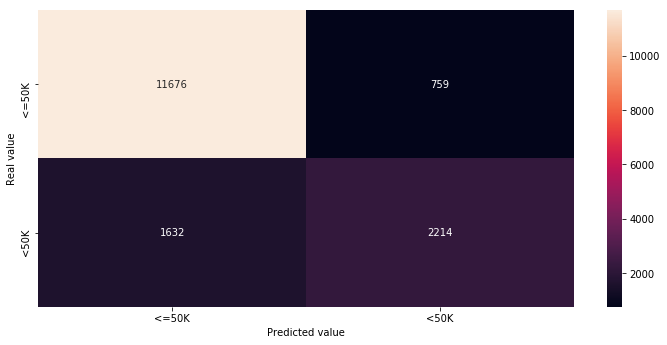

In [23]:
# evaluation metrics
print("Test Accuracy:", format(metrics.accuracy_score(y_test, predicted) * 100, '.2f'), '%')
print("F1 Score:", format(metrics.f1_score(y_test, predicted), '.2f'))

cm = metrics.confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['<=50K', '<50K'], yticklabels=['<=50K', '<50K'])
plt.ylabel("Real value")
plt.xlabel("Predicted value")

Perform GridSerach to tune the hyper parameters, then use the best estimator for scoring on the test set.

In [24]:
param_test1 = {
 'max_depth': range(3, 10, 2),
 'n_estimators': range(100, 500, 1000),
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 3, 5],
 'max_features': [3, 5, 7],
}

grid_search = GridSearchCV(rfmodel, param_grid=param_test1, scoring="roc_auc", n_jobs=-1, verbose=1)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  4.0min finished


Best: 0.916191 using {'max_depth': 9, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [25]:
predicted = grid_result.predict(X_test)
predicted

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

Test Accuracy: 85.97 %
F1 Score: 0.65


Text(0.5,442.811,'Predicted value')

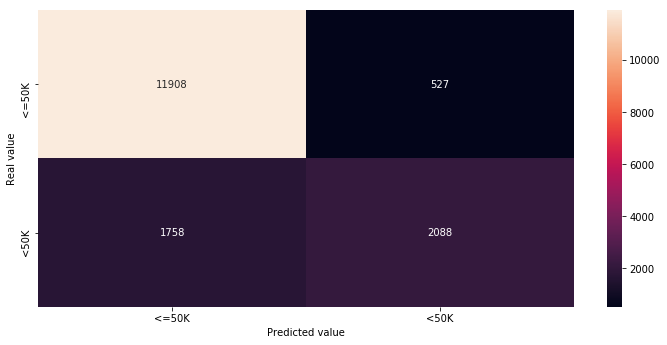

In [26]:
# evaluation metrics
print("Test Accuracy:", format(metrics.accuracy_score(y_test, predicted) * 100, '.2f'), '%')
print("F1 Score:", format(metrics.f1_score(y_test, predicted), '.2f'))

cm = metrics.confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['<=50K', '<50K'], yticklabels=['<=50K', '<50K'])
plt.ylabel("Real value")
plt.xlabel("Predicted value")

The accuracy score has increased by 0.66%. Check feature importance.

In [27]:
feat_labels = ['workclass', 'marital-status', 'occupation', 'relationship', 'race',
               'sex', 'native-country', 'age', 'capital-gain', 'capital-loss',
               'education-num', 'fnlwgt', 'hours-per-week']

for feature in zip(feat_labels, grid_result.best_estimator_.feature_importances_):
    print(feature)

('workclass', 0.06593737290266051)
('marital-status', 0.007825417988499566)
('occupation', 0.01252132264987309)
('relationship', 0.18225968782751814)
('race', 0.07964556330464548)
('sex', 0.026116610340960106)
('native-country', 0.2804751213304822)
('age', 0.002050581852915335)
('capital-gain', 0.007544963332464822)
('capital-loss', 0.22825591508041407)
('education-num', 0.05580299770923593)
('fnlwgt', 0.04796585644898718)
('hours-per-week', 0.003598589231343467)


Lets select a threshold of 0.05 to select important features

In [28]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(grid_result.best_estimator_, threshold=0.05)
sfm.fit(X_train, y_train)

print ("Important features:\n")

for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

Important features:

workclass
relationship
race
native-country
capital-loss
education-num


We can try training the model only on the important features and see how it impacts the accuracy score

In [29]:
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [30]:
rfmodel_important = grid_result.best_estimator_
rfmodel_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=7248, verbose=0,
            warm_start=False)

In [31]:
predicted = rfmodel_important.predict(X_important_test)
predicted

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

Test Accuracy: 85.84 %
F1 Score: 0.64


Text(0.5,442.811,'Predicted value')

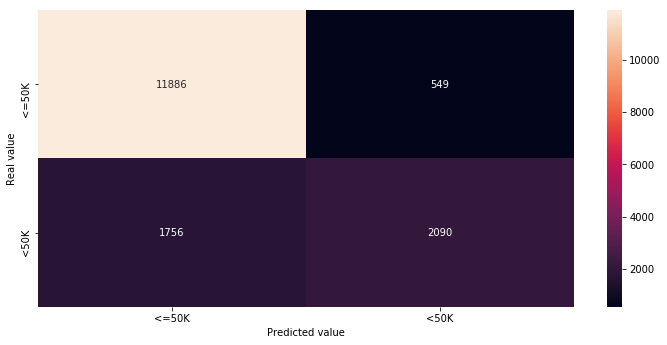

In [32]:
# evaluation metrics
print("Test Accuracy:", format(metrics.accuracy_score(y_test, predicted) * 100, '.2f'), '%')
print("F1 Score:", format(metrics.f1_score(y_test, predicted), '.2f'))

cm = metrics.confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['<=50K', '<50K'], yticklabels=['<=50K', '<50K'])
plt.ylabel("Real value")
plt.xlabel("Predicted value")

Looks great, the accuracy has decreased only a little while the F1 score remains the same and we were able to simplify the model by reducing the number of features.

# Conclusion

Looking at the above analysis, both Logistic and Random Forest models have produced nearly same accuracy and F1 scores. Both needed some tuning though. Logistic produced the best results when categorical columns were dummified. With random forest, we were able to reduce the number of features, but had to perform cross validation and grid search to tune the hyper parameters.

I would choose logistic regression as the classification algorithm for this dataset, because it's faster and intepretable.